# Homework 1 - ORF finding: how many genes are in the SARS-Cov-2 genome?

Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is a strain of coronavirus that causes COVID-19. Throughout these homework assignments, we will analyze this virus and try to understand its origins and inner workings. We will implement the necessary bioinformatics tools and apply them to further our understanding of this pesky little virus.

First, we will analyze the main component of every organism - its genetic material. Our focus will be on the genes, parts of the genetic material that code for proteins. Proteins are the main macromolecular actors in every organism.

**Why are we so interested in genes?**

Genes dictate the behavior of an organism, such as replication, viral assembly, and even innate immune evasion. If we compare the genes from this new virus with genes from other known viruses, we can get a good idea of how this virus works and maybe even how to stop it. When these genes are translated into proteins, they start acting out their function. Some proteins can attach to human cells and allow viruses to enter them. If we can figure out which genes these are, they will make good candidates for drug targets.

We can find potential genes in a genome by looking for common patterns shared across all genes. However, validating that these potential candidates are, in fact, real genes requires experimental confirmation.

**The aim of this homework**

In this homework, our goal is to find potential genes in the SARS-CoV-2 genome and take a first stab at figuring out what their corresponding proteins do. When looking for genes in an unknown genome, we consider all the Open Reading Frames (ORFs) as potential gene candidates. However, many of our ORFs will not be true genes, and since each ORF must be experimentally validated in the lab, we will try to reduce the number of ORFs only to include the most likely gene candidates. We heard in lectures that one approach for filtering ORFs is to perform a permutation test to determine a threshold indicating the minimum length of ORFs. This will reduce the number of false positives that we generate. So, our approach might be to first find the ORFs, remove ORFs that are likely too short, and then determine what each ORF might do.

However, before we jump right into the SARS-CoV-2 genome, we first want to convince ourselves that this is, in fact, a reasonable approach that produces good results. Since we are going to pretend that SARS-CoV-2 is an unknown virus, we can't check our results to see if they are correct. So instead, we will validate our approach on one of the most well-understood organisms in existence: _E. Coli_. Here, we will be able to check how many of our ORFs are true genes and how well our threshold selection method actually works.

Once we've convinced ourselves that this is, in fact, a good approach, we will start exploring the SARS-CoV-2 genome. Finally, once we have found and filtered our coronavirus ORFs, we will implement a simple classification technique to determine the function of their corresponding proteins. We will explore computational techniques for determining protein function in the next homework.


In [1]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq

Let's let the nice folks at NCBI know who we are.

In [2]:
Entrez.email = "ls6727@student.uni-lj.si"

In [3]:
# In order to import from the `helper_functions` python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

## _Escherichia coli_


[_Escherichia coli_](https://en.wikipedia.org/wiki/Escherichia_coli) (_E. Coli_) is a bacteria commonly found in the human intestine. Most strains are harmless to humans, at worse, causing food poisoning and diarrhea. They can survive outside a host for only a short period of time, making it a potential indicator of fecal contamination.

Over the years, _E. Coli_ has been intensely studied and is probably one of the most well-understood organisms in existence. We've learned how to grow them in an optimal environment where they can reproduce up to once every 20 minutes. Due to their rapid growth and easy manipulation, biologists often use them to produce recombinant proteins.

![](https://upload.wikimedia.org/wikipedia/commons/4/40/E.coli-colony-growth.gif)

Image source: https://doi.org/10.1371/journal.pbio.0030045

Recombinant proteins are proteins that wouldn't naturally appear in that organism. For instance, we can insert genes that code for fluorescence into plants, making them glow in the dark. Or, perhaps more usefully, we can take the human gene that codes for insulin and convince _E. Coli_ to produce insulin instead. Insulin that we can then use to treat diabetic patients. Or proteins used in cancer treatment. Or, more recently, we can insert fragments of the SARS-CoV-2 virus into _E. Coli_ and use that to produce COVID-19 vaccines.

![](https://static.dezeen.com/uploads/2014/01/American-firm-genetically-engineers-worlds-first-glow-in-the-dark-plant-_dezeen_4.jpg)

Image source: [Discover magazine](https://www.discovermagazine.com/planet-earth/for-sale-plants-that-glow-in-the-dark)

_E. coli_ is a very well-studied organism, therefore, well-annotated. This means we can quickly check our work for any analysis we might perform because we have the ground truth, which biologists have spent decades meticulously gathering for us. We will examine the DNA sequence of _E. coli_ and implement an algorithm for finding potential gene candidates. Because the ground truth is readily available, we can check how many of our ORF candidates are actual genes and how many candidates are false positives.

Every organism in NCBI has an associated unique identifier, which we can use to download various genomes and other kinds of data. The NCBI ID for _E. coli_ is _NC_000913_.

In [4]:
organism_id = "NC_000913"  # E. coli

Fetch the _E. coli_ genome from NCBI. To check you have the right one, the genome should be 4,641,652 base pairs long. It might take up-to a minute to download.

_Hint_: Use the `Entrez.efetch` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec149) and `SeqIO.read` (http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec37) functions from biopython.
Use `rettype="gbwithparts"` to fetch all required features.

In [5]:
#record_ecoli = ...
with Entrez.efetch(db="nucleotide", id=organism_id, rettype="gbwithparts", retmode="text") as handle:
    record_ecoli = SeqIO.read(handle, "genbank")

record_ecoli.seq

Seq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC')

## Problem 1: Finding gene candidates

Before we get started, we need to implement an algorithm for finding all open reading frames (ORFs) in a given genome. We define an ORF as the longest contiguous sequence of triplets (codons) between a start and a stop codon. For instance, TTATGAAAATGAAATGATT contains one ORF -- ATGAAAATGAAATGA spanning from locations 2 to 17.

**TASK:**
Implement the `find_orfs` and `find_all_orfs` functions in `helper_functions.py`. Function `find_orfs` should find ORFs for a single offset e.g. [ATGTAATGTTGATTA]TG, ignoring the final TG. `find_all_orfs` should use `find_orfs` to find _all_ the ORFs in a sequence, i.e. [ATGTAATGTTGATTA]TG, A[TGTAATGTTGATTAT]G, AT[GTAATGTTGATTATG], as well as the ORFs on the reverse complements. See the docstrings for expected return types.

Returned ORFs should be of the form (strand, start_loc, stop_loc). Here, start_loc and stop_loc correspond to the starting and ending locations of the ORFs and not necessarily to the START and STOP codons. For instance, if the ORF is on the negative strand, the start_loc location should refer to the position of the STOP codon. The start_loc should always be smaller than stop_loc for ORFs at either strand.
The strand should be indicated by either 1 for the reference strand and -1 for its reverse complement. We consider stop codons as part of an ORFs. The positions of ORFs on the reverse complement strand should specified according to the reference strand.

**[10 points]**

_Hint_: You can check your implementation on the _E. Coli_ genome, where the number of ORFs on the positive and negative strands should be roughly equal.

In [6]:
from helper_functions import find_all_orfs

orfs = find_all_orfs(record_ecoli.seq, ['ATG'], ['TAA', 'TAG', 'TGA'])

print(f"Found {len(orfs)} ORFs in the E. coli genome")

positive_orfs = [orf for orf in orfs if orf[0] == 1]
negative_orfs = [orf for orf in orfs if orf[0] == -1]

print(f"Found {len(positive_orfs)} ORFs on the positive strand")
print(f"Found {len(negative_orfs)} ORFs on the negative strand")

Found 81687 ORFs in the E. coli genome
Found 40954 ORFs on the positive strand
Found 40733 ORFs on the negative strand


In [7]:
print(list(sorted(orfs, key=lambda x: x[1])[:10]))

[(1, 29, 98), (-1, 51, 93), (-1, 130, 196), (-1, 161, 287), (1, 189, 255), (-1, 195, 240), (1, 336, 2799), (1, 373, 487), (-1, 390, 405), (-1, 401, 494)]


## Problem 2: Finding true genes

Having implemented our ORF finder, we can now apply it to the _E. Coli_ genome to find the ORFs, i.e., gene candidates. You will see that there are quite a large number of these. Some of them might be actual genes, and some may not. In practice, biologists will often look through each gene candidate manually to determine if it is a gene or not. We want to help them by reducing the number of ORFs they'll have to look through. One way to reduce this number is to set a threshold for our ORF lengths. As you saw in lectures, we can determine a sensible threshold using a permutation test.

**TASK:**

**a)** Find all the ORFs in the _E. Coli_ genome. Determine a reasonable threshold for filtering short ORFs using a permutation test with 100 repetitions such that we keep only sequences with $p < 0.01$. Plot a histogram of the distribution of ORF lengths in these random sequences using the log scale for the y-axis. The x-axis should not be shown in log scale. Overlay the histogram with the ORF lengths you found using your ORF finder. Clearly indicate the permutation test threshold on your plot. Save your threshold into the `bacteria_threshold` variable and save your plot into `problem2-permutation.png`. All ORF lengths and thresholds should be reported **in codons**.

**[5 points]**

Note that the _E. coli_ permutation test might run up to an hour on some computers. In bioinformatics, it is very common to have to wait a long time for results to compute since we generally deal with large amounts of data. Efficient implementations and caching can help a great deal.

_Hint_: For plotting, you can use the [`hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) function from [matplotlib](https://matplotlib.org/stable/index.html).

In [8]:
start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

In [9]:
# Analyze the lengths of the ORFs.

from helper_functions import find_all_orfs

orfs = find_all_orfs(record_ecoli.seq, start_codons, stop_codons)

average_length = 0
orf_lengths = []

for orf in orfs:
    average_length += abs(orf[2] - orf[1]) + 1
    orf_lengths.append(((abs(orf[2] - orf[1]) / 3), orf))

average_length /= len(orfs)

print(f"The average length of an ORF in the E. coli genome is {average_length:.2f} nucleotides")
print(orf_lengths[:10])

The average length of an ORF in the E. coli genome is 125.72 nucleotides
[(22.0, (1, 189, 255)), (821.0, (1, 336, 2799)), (28.0, (1, 5058, 5142)), (46.0, (1, 5214, 5352)), (19.0, (1, 5418, 5475)), (80.0, (1, 6138, 6378)), (8.0, (1, 6654, 6678)), (36.0, (1, 7086, 7194)), (136.0, (1, 7365, 7773)), (62.0, (1, 7803, 7989))]


In [10]:
# Perform a permutation test to determine the threshold for the ORF lengths.

import random
import numpy as np

random.seed(42)

repetitions = 100
p = 0.01

def permutation_test(seq):
    """
    Perform a permutation test on the given sequence.

    Args:
        seq (str): The sequence to test.

    Returns:
        list: A list of lengths of ORFs found in the permuted sequences.
    """
    lengths = []
    for _ in range(repetitions):
        seq = list(seq)
        random.shuffle(seq)
        seq = Seq("".join(seq))
        orfs = find_all_orfs(seq, start_codons, stop_codons)

        for orf in orfs:
            # Report the length in codons, hence the division by 3.
            lengths.append(abs(orf[2] - orf[1]) / 3)

    return lengths

permutation_orf_lengths = permutation_test(record_ecoli.seq)

print(f"Performed permutation test with {repetitions} repetitions and p = {p}")
thresholded_orfs = np.quantile(permutation_orf_lengths, 1 - p)

print(f"The threshold for the permutation test is {thresholded_orfs:.2f}")

Performed permutation test with 100 repetitions and p = 0.01
The threshold for the permutation test is 100.00


In [11]:
bacteria_threshold = 100

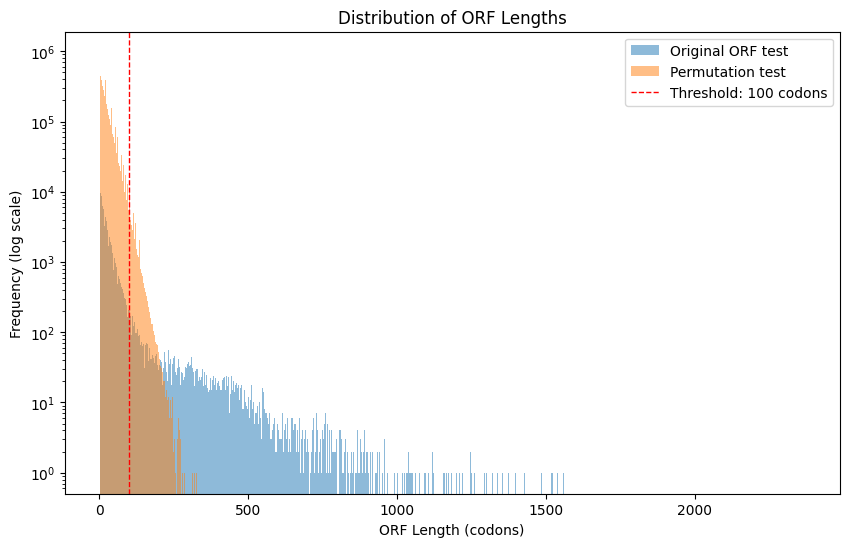

In [12]:
# Plot the distribution of ORF lengths.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

tmp_list = [x[0] for x in orf_lengths]

plt.hist(tmp_list, len(set(tmp_list)), log=True, alpha=0.5, label='Original ORF test')
plt.hist(permutation_orf_lengths, len(set(permutation_orf_lengths)), log=True, alpha=0.5, label='Permutation test')

# Add vertical line for threshold.
plt.axvline(bacteria_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Threshold: {bacteria_threshold} codons')

# Customize plot.
plt.xlabel('ORF Length (codons)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of ORF Lengths')
plt.legend()

# Save plot.
plt.savefig('problem2-permutation.png')
plt.show()

Is this a good threshold? As we said in the beginning, _E. coli_ is a well-studied organism, so we can easily evaluate our filtering proceedure with the ground truth. We can use many metrics to evaluate our accuracy, but here, we will focus on three: precision, recall, and the F1 score. Please consult Wikipedia if you aren't familiar with these metrics. To calculate each metric, we first have to apply our chosen threshold to our found ORFs, removing ORFs that are too short. Using the ground truth ORFs, we can then identify true positives, false positives, true negatives, and false negatives.

**TASK:**

**b)** Could a different threshold give better precision/recall/F1 scores? Generate a list of possible thresholds and compute precision/recall/F1 scores for each threshold. Plot all three metrics into a single figure. Based on these metrics, can you determine a better threshold? Clearly indicate your suggested threshold as well as the threshold suggested by the permutation test in the plot. Save the resulting figure to `problem2-proc.png`.

Then, based on your plot, answer the following questions:
- Is the threshold determined by the permutation test reasonable? Explain your answer.
- What would we be the advange of using a higher and a lower threshold value? Explain your reasoning.

Store your answers in the `permutation_threshold_reasonable` and `different_thresholds` variables, respectively.

**[5 points]**

The true ORFs can be extracted from the Biopython record object using the provided `extract_gt_orfs` function in `helper_functions.py`.

In [13]:
from helper_functions import extract_gt_orfs

print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record_ecoli, start_codons, stop_codons, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

Extracting ORFs from NCBI annotation...
3868 ground truth ORFs found


In [14]:
# Find the Recall, Precision and F1 score for the data in exercise a)

filtered_orf_lengths_higher = [x[1] for x in orf_lengths if x[0] >= bacteria_threshold]
filtered_orf_lengths_lower = [x[1] for x in orf_lengths if x[0] < bacteria_threshold]

TP, FP, TN, FN = 0, 0, 0, 0

# Calculate the number of true positives, false positives, true negatives and false negatives.
# We use set operations to speed up the process.
orf_lengths_elements = set([x[1] for x in orf_lengths])

# True positives are elements that are present in both the orfs_gt and orf_lengths_higher sets.
TP = len(set(filtered_orf_lengths_higher) & set(orfs_gt))
# True negatives are elements that are present in the orf_lengths_lower set, but not in the orfs_gt set + 
# elements that are peresent in the orfs_gt set but were not found.
TN = len(set(filtered_orf_lengths_lower) - set(orfs_gt)) + len(set(orfs_gt) - set(orf_lengths_elements))
# False positives are elements that are present in the orf_lengths_higher set, but not in the orfs_gt set.
FP = len(set(filtered_orf_lengths_higher) - set(orfs_gt))
# False negatives are elements that are present in the orf_lengths_lower set and in the orfs_gt set +
# all that are in the orfs_gt set but were not found.
FN = len(set(filtered_orf_lengths_lower) & set(orfs_gt)) + len(set(orfs_gt) - set(orf_lengths_elements))


print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

# Calculate the recall, precision and F1 score.
recall = TP / (TP + FN)
precision = TP / (TP + FP)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"Recall: {recall:.2f}, Precision: {precision:.2f}, F1: {f1:.2f}")

TP: 1372, FP: 4679, FN: 2496, TN: 77738
Recall: 0.35, Precision: 0.23, F1: 0.28


In [15]:
# Perform analysis of different thresholds to determine which one performs the best in terms of recall, precision and F1 score.

current_threshold = bacteria_threshold
current_f1 = f1

recall_scores = []
precision_scores = []
f1_scores = []

repetitions = 500

for threshold in range(0, repetitions):
    filtered_orf_lengths_higher = [x[1] for x in orf_lengths if x[0] >= threshold]
    filtered_orf_lengths_lower = [x[1] for x in orf_lengths if x[0] < threshold]

    TP, FP, TN, FN = 0, 0, 0, 0

    # Calculate the number of true positives, false positives, true negatives and false negatives.
    # We use set operations to speed up the process.
    orf_lengths_elements = set([x[1] for x in orf_lengths])

    # True positives are elements that are present in both the orfs_gt and orf_lengths_higher sets.
    TP = len(set(filtered_orf_lengths_higher) & set(orfs_gt))
    # True negatives are elements that are present in the orf_lengths_lower set, but not in the orfs_gt set +
    TN = len(set(filtered_orf_lengths_lower) - set(orfs_gt)) + len(set(orfs_gt) - set(orf_lengths_elements))
    # False positives are elements that are present in the orf_lengths_higher set, but not in the orfs_gt set.
    FP = len(set(filtered_orf_lengths_higher) - set(orfs_gt))
    # False negatives are elements that are present in the orf_lengths_lower set and in the orfs_gt set +
    FN = len(set(filtered_orf_lengths_lower) & set(orfs_gt)) + len(set(orfs_gt) - set(orf_lengths_elements))

    # Calculate the recall, precision and F1 score.
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1 = 2 * (precision * recall) / (precision + recall)

    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

    if f1 > current_f1:
        current_threshold = threshold
        current_f1 = f1

print(f"Best threshold: {current_threshold}, F1: {current_f1:.2f}")

Best threshold: 150, F1: 0.30


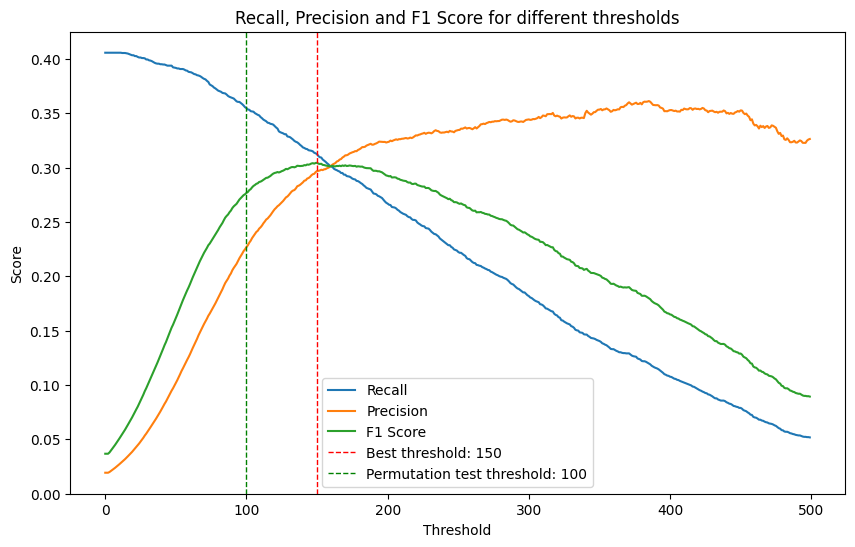

In [16]:
# Plot the recall, precision and F1 scores for different thresholds.

plt.figure(figsize=(10, 6))

plt.plot(range(0, repetitions), recall_scores, label='Recall')
plt.plot(range(0, repetitions), precision_scores, label='Precision')
plt.plot(range(0, repetitions), f1_scores, label='F1 Score')

plt.axvline(current_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Best threshold: {current_threshold}')
plt.axvline(bacteria_threshold, color='green', linestyle='dashed', linewidth=1, label=f'Permutation test threshold: {bacteria_threshold}')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall, Precision and F1 Score for different thresholds')

plt.legend()

plt.savefig('problem2-proc.png')

plt.show()

In [17]:
permutation_threshold_reasonable = """
Is the threshold determined by the permutation test reasonable? Explain your answer with reasoning.

The threshold determined by the permutation test is reasonable because it is based on a statistical method that accounts for the distribution of ORF lengths in 
random sequences. By comparing the ORF lengths found in the actual genome to those found in randomly permuted sequences, we can identify a threshold that distinguishes 
true ORFs from random occurrences. This helps to minimize false positives and ensures that the identified ORFs are more likely to be biologically relevant.
"""

In [18]:
different_thresholds = """
What would we be the advange of using a higher and a lower threshold value? Explain your reasoning.

Different thresholds can be used to balance the trade-off between sensitivity and specificity. A lower threshold may increase sensitivity, 
allowing more true ORFs to be detected, but it may also increase the number of false positives while a higher threshold may increase 
specificity, reducing false positives, but it may also miss some true ORFs.
"""

# SARS-CoV-2

SARS-CoV-2 is the prolific virus that causes the COVID-19 disease. We am sure most of you are well aware of what the disease does, so we'll skip any long-winded introduction. Instead, we'll jump straight into the genome of this pesky little virus.

![](https://www.klinika-golnik.si/storage/_sites/golnik/app/media/Novice/cov-19.jpg)

Image source: [klinika-golnik.si]()

## Problem 3: SARS-CoV-2 gene candidates

Having convinced ourselves sufficiently that our gene-candidate-finding procedure produces reasonable results, we can now turn our attention to the SARS-CoV-2 genome, which can be found in `data/sars_cov_2.txt`. Remember, we have no ground truth annotations about SARS-CoV-2 from NCBI, so it's up to you to find potential gene candidates and try to determine what each gene does.

**TASK:**
Run your ORF finder on the SARS-CoV-2 genome. Again, using a permutation test with 100 repetitions, determine a threshold for ORF lengths such that we keep only sequences with $p < 0.01$. As in the _E. Coli_ case, plot the distribution of ORF lengths in the random sequences and overlay this with your ORF lengths. Clearly indicate the permutation test threshold on the plot. Save your plot to `problem3.png`. Save your threshold into the `covid_threshold` variable.

Then, answer the following questions:
- Is this threshold the same as the one you got for _E. coli_? Why or why not? *Hint: Inspect the distributions of nucleotides for each organism.*
- Can we perform the same F1/precision/recall experiment as we did for _E. Coli_ for SARS-CoV-2? Why or why not?

Store your answers in the `different_thresholds` and `covid_proc_experiment` variables, respectively.

**[5 points]**

In [19]:
start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

In [20]:
# Open the data/sars_cov_2.txt file and read the sequence.

with open("data/sars_cov_2.txt", "r") as file:
    sars_cov_2_seq = Seq(file.read().strip())

# Find all ORFs in the SARS-CoV-2 sequence.
cov_orfs = find_all_orfs(sars_cov_2_seq, start_codons, stop_codons)

# Create a list of ORF lengths.
cov_orf_lengths = []

for orf in cov_orfs:
    cov_orf_lengths.append(((abs(orf[2] - orf[1]) / 3), orf))

In [21]:
# Perform the permutation test on the SARS-CoV-2 sequence.

permutation_cov_orf_lengths = permutation_test(sars_cov_2_seq)

# Calculate the threshold for the permutation test.
cov_threshold = np.quantile(permutation_cov_orf_lengths, 1 - p)

print(f"The threshold for the permutation test on the SARS-CoV-2 sequence is {cov_threshold:.2f}")

The threshold for the permutation test on the SARS-CoV-2 sequence is 68.00


In [22]:
covid_threshold = 68

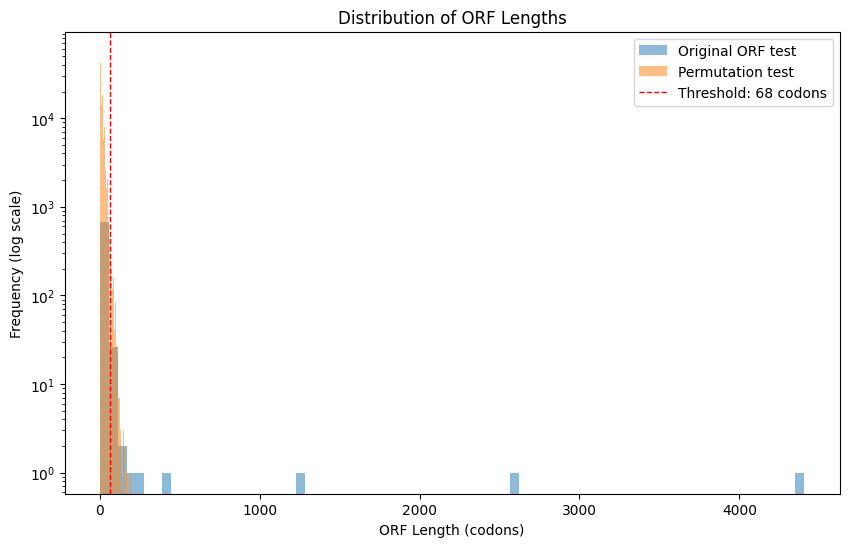

In [23]:
# Plot the histogram of ORF lengths for the SARS-CoV-2 sequence.

plt.figure(figsize=(10, 6))

tmp_list = [x[0] for x in cov_orf_lengths]

plt.hist(tmp_list, len(set(tmp_list)), log=True, alpha=0.5, label='Original ORF test')
plt.hist(permutation_cov_orf_lengths, len(set(permutation_cov_orf_lengths)), log=True, alpha=0.5, label='Permutation test')

# Add vertical line for threshold.
plt.axvline(covid_threshold, color='red', linestyle='dashed', linewidth=1, label=f'Threshold: {covid_threshold} codons')

# Customize plot.
plt.xlabel('ORF Length (codons)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of ORF Lengths')
plt.legend()

# Save plot.
plt.savefig('problem3.png')

plt.show()

In [24]:
different_thresholds = """
Is this threshold the same as the one you got for E. coli? Why or why not?

The threshold for the SARS-CoV-2 sequence is different from the one obtained for E. coli, which is expected because the threshold is based on the 
distribution of ORF lengths in the specific genome being analyzed. Since the SARS-CoV-2 genome is different from the E. coli genome, it is expected 
that the threshold for identifying ORFs are different.
"""

In [25]:
covid_proc_experiment = """
Can we perform the same F1/precision/recall experiment as we did for E. Coli for SARS-CoV-2? Why or why not?

In theory we could, but the ground truth ORFs for the SARS-CoV-2 genome are not provided in the same way as they were for E. coli - this is probably
due to the fact that the SARS-CoV-2 genome is not as well understood as the E. coli genome.
"""

## Problem 4: Determining gene functionality from amino acid sequence

Okay, so we've found and filtered down our gene candidates, but now what? The next step is to figure out what these genes might do. So, what _do_ these genes do? Well, nothing by themselves. If DNA is the cookbook, then the genes are the recipes. They tell us how to prepare each dish. Recipes by themselves are nothing but information. It is the actual dishes we care about: the proteins. It is the proteins that actually _do_ things inside our cells.

An organism can read codons in ORFs (hence open-READING-frame) and translate the language of codons into amino acids. Codons in a DNA sequence are translated into amino acids consecutively, forming a long chain. The amino acid chain folds into a macromolecule called protein (as shown in the picture below). Their 3D structure is crucial for their function.
We can predict protein characteristics from the amino acid sequence, such as their location in a cell. However, for a more concrete prediction of the functionality, we would have to use more sophisticated approaches, such as BLAST or AlphaFold.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Protein_folding.png/360px-Protein_folding.png)

Image source: [Wikipedia](https://en.wikipedia.org/wiki/Protein_folding#/media/File:Protein_folding.png)

**Intro to hydrophobicity**

The hydrophobicity of an amino acid is its tendency to repel water molecules. These amino acids tend to stick together in a non-polar environment. One well-known example of hydrophobicity is the lipid membrane of cells. This hydrophobic cell membrane ensures that the environment outside the cell (water and anything inside that water) stays outside, and all the important bits of the cell (e.g., the mitochondria, nucleus, ribosomes) stay inside the cell.

![](https://i.pinimg.com/originals/5f/44/ac/5f44ac7665a7c003342dca018ce23077.jpg)

Image source: [Pinterest](https://www.pinterest.com/pin/488007309597008815/)

Hydrophilic proteins cannot pass through the hydrophobic membrane since its hydrophobic interior will repel them, but hydrophobic proteins can sit happily embedded inside the membrane. These hydrophobic proteins are called _transmembrane_ proteins. Transmembrane proteins typically function as transport channels between the interior and exterior of the cell and enable cell signaling and absorption. In the case of viruses, e.g., SARS-CoV-2, we expect at least some proteins to be embedded in the viral membrane. For instance, SARS-CoV-2 viruses can only enter human cells when the spike protein that sticks out on the exterior of the virus binds to a specific receptor in human cells.

![](https://o.quizlet.com/qBs-A5bu4m1ZI4IdWv1OUA_b.png)

Image source: [Quizlet](https://quizlet.com/331498946/structure-of-transmembrane-proteins-diagram/)

Transmembrane proteins usually contain more hydrophobic amino acids than other proteins because their environment is a strictly hydrophobic lipid membrane. Therefore, one naive approach to finding transmembrane proteins might be to look for proteins with a high degree of hydrophobicity.


The less-biological explanation of all this might be that the little, yellow hydrophobic tails of the lipids in the membrane attract each other because they are all hydrophobic. They can also attract proteins, provided that the amino acids inside that protein are also hydrophobic. The little hydrophobic tails also repel anything hydrophilic, so hydrophilic proteins can't pass through the hydrophobic membrane. So, simply put, hydrophobic molecules attract other hydrophobic molecules and repel any hydrophilic molecules. Finally, hydrophobic molecules repel water, while hydrophilic molecules are drawn toward water.

**TASK**:

**a)** Implement the `translate_to_protein` function in `helper_functions.py`. Do not use Biopython for this in this homework -- we want you to implement this yourself. Stop codons should translate into an empty string ("").

**[5 points]**

In [26]:
from helper_functions import translate_to_protein

print("Translating test sequences to protein sequences...")
print(translate_to_protein("ATGTTTATGCTGCTAGCGTCTG")) # Expected: MFMLLAS
print(translate_to_protein("TTTGCATTCCGG")) # Expected: FAFR
print(translate_to_protein("TTGCATTCC")) # Expected: LHS

Translating test sequences to protein sequences...
MFMLLAS
FAFR
LHS


**b)** Use the function `extract_gt_orfs` from `helper_functions.py` with parameter `validate=False` to extract all available genes for _E. Coli_. Translate these ground truth genes to protein sequences and calculate their average hydrophobicity. The average protein hydrophobicity is calculated as the average hydrophobicity of all amino acids in the protein sequence. You can find the hydrophobicity values for each amino acid in `data/aminoacid_properties.csv`.

Next, find, filter, and translate the ORFs (found by your ORF finder and filtered according to the permutation test threshold) in the SARS-CoV-2 genome and calculate the average hydrophobicity of these potential proteins.

Plot the distribution of the average hydrophobicities for all proteins found in _E. coli_. Overlay this distribution with a scatter plot of the hydrophobicity values of your SARS-CoV-2 protein candidates. Save the resulting figure to `problem4.png`.

Inspect the distribution of the bacterial proteins. Are there proteins that seem to have a larger hydrophobicity than others? If so, these would probably be good candidates for transmembrane proteins. Compare these to the hydrophobicities of the SARS-CoV-2 proteins you showed with a scatter plot. Are there any proteins in the SARS-CoV-2 genome that we could classify as transmembrane proteins just by referencing the distribution of bacterial proteins? If so, save the ORFs you think may correspond to transmembrane proteins to the `transmembrane_candidates` variable.

*Hint: you should be able to find between 2-4 transmembrane protein candidates in the SARS-CoV-2 genome.*

**[10 points]**

In [27]:
# Translate the E. coli genome to protein sequences.

print("Extracting ORFs from NCBI annotation...")
orfs_gt = extract_gt_orfs(record_ecoli, start_codons, stop_codons, validate_cds=False, verbose=False)
print(f"{len(orfs_gt)} ground truth ORFs found")

list_of_ecoli_proteins = []

for orf in orfs_gt:
    if orf[0] == 1:
        protein_sequence = translate_to_protein(str(record_ecoli.seq[orf[1]:orf[2]]))
    else:
        protein_sequence = translate_to_protein(str(record_ecoli.seq[orf[1]:orf[2]].reverse_complement()))
    list_of_ecoli_proteins.append(protein_sequence)
    


Extracting ORFs from NCBI annotation...
4298 ground truth ORFs found


In [28]:
# Calculate the average hydrophobicity of E. coli proteins.

import pandas as pd
hydrophobicity_data = pd.read_csv("data/aminoacid_properties.csv")

hydrophobicity_dict = dict(zip(hydrophobicity_data['aminoacid'], hydrophobicity_data['hydrophobicity']))

def calculate_hydrophobicity(protein_sequence):
    """
    Calculate the hydrophobicity of a protein sequence.

    Args:
        protein_sequence (str): The protein sequence.

    Returns:
        float: The hydrophobicity of the protein sequence.
    """
    hydrophobicity = 0
    for aa in protein_sequence:
        hydrophobicity += hydrophobicity_dict[aa]
    return hydrophobicity / len(protein_sequence)

ecoli_hydrophobicities = []

for protein in list_of_ecoli_proteins:
    ecoli_hydrophobicities.append(calculate_hydrophobicity(protein))

In [29]:
# Calculate the average hydrophobicity of SARS-CoV-2 proteins.

start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

with open("data/sars_cov_2.txt", "r") as file:
    sars_cov_2_seq = Seq(file.read().strip())

# Find all ORFs in the SARS-CoV-2 sequence.
cov_orfs = find_all_orfs(sars_cov_2_seq, start_codons, stop_codons)

# Create a list of ORF lengths.
cov_orf_lengths = []

for orf in cov_orfs:
    cov_orf_lengths.append((abs(orf[2] - orf[1]) / 3, orf))

# Filter the ORFs based on the threshold obtained by the permutation test.
filtered_cov_orfs = [orf[1] for orf in cov_orf_lengths if orf[0] >= covid_threshold]

# Translate the ORFs to protein sequences.
list_of_cov_proteins = []

for orf in filtered_cov_orfs:
    if orf[1] == 1:
        protein_sequence = translate_to_protein(str(sars_cov_2_seq[orf[1]:orf[2]]))
    else:
        protein_sequence = translate_to_protein(str(sars_cov_2_seq[orf[1]:orf[2]].reverse_complement()))
    list_of_cov_proteins.append(protein_sequence)

# Calculate the average hydrophobicity of SARS-CoV-2 proteins. 

cov_hydrophobicities = []

for protein in list_of_cov_proteins:
    cov_hydrophobicities.append(calculate_hydrophobicity(protein))


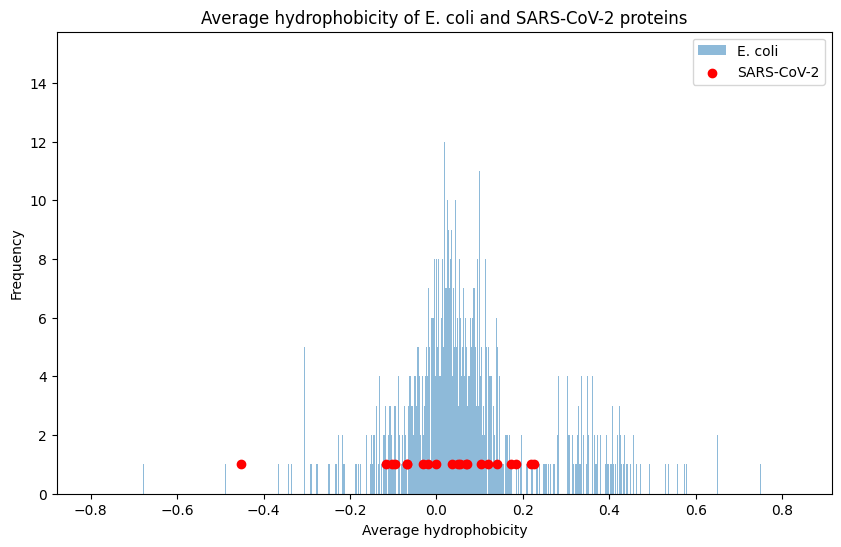

In [30]:
# Plot the hydrophobicity graph.

plt.figure(figsize=(10, 6))
plt.hist(ecoli_hydrophobicities, len(set(ecoli_hydrophobicities)), alpha=0.5, label='E. coli')

# Overlay the scatterplot for SARS-CoV-2 hydrophobicities.
number_of_appearances = []
for hydrophobicity in cov_hydrophobicities:
    number_of_appearances.append(cov_hydrophobicities.count(hydrophobicity))

plt.scatter(cov_hydrophobicities, number_of_appearances, color='red', label='SARS-CoV-2')

plt.xlabel('Average hydrophobicity')
plt.ylabel('Frequency')

plt.title('Average hydrophobicity of E. coli and SARS-CoV-2 proteins')

plt.legend()

plt.savefig('problem4.png')

plt.show()

In [31]:
# Find the transmembrane candidates in the SARS-CoV-2 sequence.

transmembrane_candidates = []

indices = []
for index, hydrophobicity in enumerate(cov_hydrophobicities):
    if hydrophobicity > 0.18:
        indices.append(index)

proteins = []
for index in indices:
    protein = list_of_cov_proteins[index]
    proteins.append(protein)

orfs = []
for index in indices:
    orfs.append(filtered_cov_orfs[index])

print(f"Found {len(proteins)} transmembrane candidates in the SARS-CoV-2 sequence")
print(orfs)

Found 3 transmembrane candidates in the SARS-CoV-2 sequence
[(1, 28273, 29533), (-1, 4096, 4318), (-1, 29236, 29482)]


In [32]:
transmembrane_candidates = [
    (1, 28273, 29533), 
    (-1, 4096, 4318), 
    (-1, 29236, 29482)
]

## Bonus problem: Visualizing ORF candidates

You may have noticed in problem 2 that even when keeping all the genes, our recall was well below 1. This means that even without any filtering, we weren't able to find all the ORFs that are actually genes. The reason for this is that we defined ORFs to be the longest contiguous sequence of codons between a start and a stop codon. This is a simplification of what really happens in biology. Not all start codons actually determine the beginning of a coding (gene) sequence. ORFs themselves can contain start codons since the ATG codon itself codes for Methionine. To be completely thorough, each start codon should start its own ORF.

In this exercise, we will define an ORF to be **any** contiguous sequence of codons between a start and a stop codon. For instance, ATGAAAATGAAATGA now contains two ORFs: ATGAAAATGAAATGA and ATGAAATGA.

**TASK**: Implement the `find_all_orfs_nested` function in `helper_functions.py`, following the above definition of an ORF. Visualize where the ORF candidates are found on the SARS-CoV-2 genome. Save your plot to `problem-orf-viz.png`.

You can look at this image for a general direction: https://www.ncbi.nlm.nih.gov/nuccore/NC_002549.1?report=graph. Take care to optimize the layout and make the plot as compact as possible while still being readable and visually appealing. If you have a different idea for an informative visualization, that's even better. Feel free to apply any kind of filtering to the ORFs in your plot.

 **[5 points]**

In [33]:
# Test the find_all_orfs_nestest function on a small sequence.

from helper_functions import find_all_orfs_nested

start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

print(find_all_orfs_nested(Seq("ATGAAAATGAAATGA"), start_codons, stop_codons)) # Expected: [(1, 0, 15), (1, 6, 15)]

[(1, 0, 15), (1, 6, 15)]


In [34]:
# Find all nested ORFs in SARS-CoV-2.

start_codons = ["ATG"]
stop_codons = ["TGA", "TAA", "TAG"]

cov_nested_orfs = find_all_orfs_nested(sars_cov_2_seq, start_codons, stop_codons)

print(f"Found {len(cov_nested_orfs)} nested ORFs in the SARS-CoV-2 genome")
print(cov_nested_orfs[:10])

Found 1208 nested ORFs in the SARS-CoV-2 genome
[(1, 900, 933), (1, 1071, 1131), (1, 1197, 1236), (1, 1254, 1278), (1, 1380, 1407), (1, 5268, 5280), (1, 6057, 6063), (1, 7209, 7272), (1, 7443, 7479), (1, 7530, 7548)]


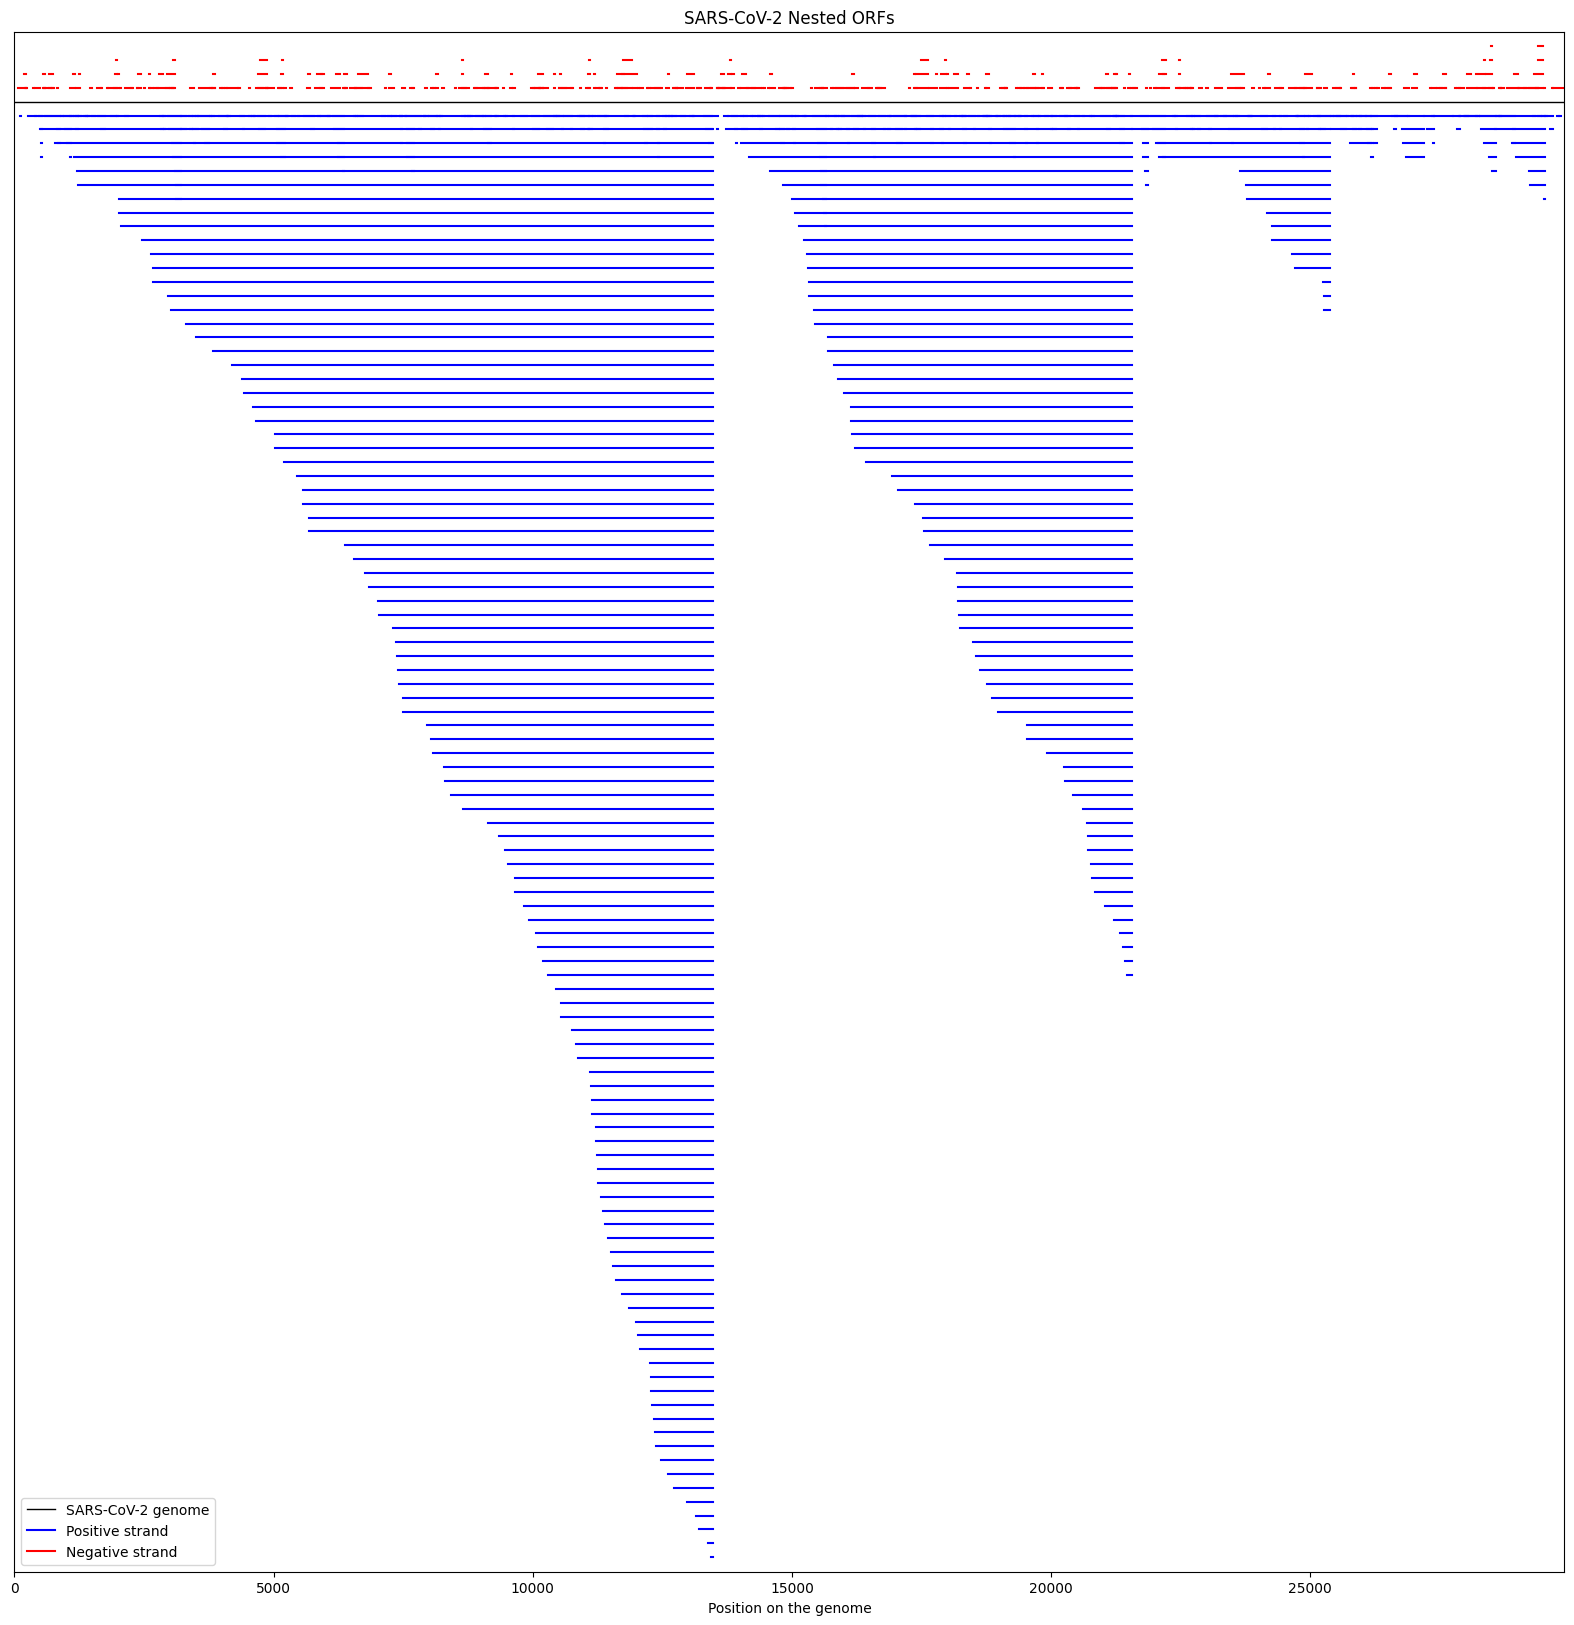

In [35]:
# Visualize the nested ORFs in the SARS-CoV-2 sequence.

import matplotlib.pyplot as plt


plt.figure(figsize=(20, 20))

# Plot the baseline sequence.
# xmin and xmax are the first position and the last position of the sequence.
plt.axhline(y=0.0, xmin=0, xmax=len(sars_cov_2_seq) / len(sars_cov_2_seq), color='black', linewidth=1, label='SARS-CoV-2 genome')
plt.xlim(0, len(sars_cov_2_seq))

positive_orfs_map = dict()
negative_orfs_map = dict()

first_positive_mapped = False
first_negative_mapped = False

for orf in cov_nested_orfs:
    if orf[0] == 1:
        # Map the ORFs the the number of times they appear in the sequence. This is used to offset the ORFs on the y-axis.
        if orf[2] not in positive_orfs_map:
            positive_orfs_map[orf[2]] = 0
        else:
            positive_orfs_map[orf[2]] += 1

        if not first_positive_mapped:
            first_positive_mapped = True
            plt.axhline(y=-0.05 - 0.05 * positive_orfs_map[orf[2]], xmin=orf[1] / len(sars_cov_2_seq), xmax=orf[2] / len(sars_cov_2_seq), color='blue', label='Positive strand')
        else:
            plt.axhline(y=-0.05 - 0.05 * positive_orfs_map[orf[2]], xmin=orf[1] / len(sars_cov_2_seq), xmax=orf[2] / len(sars_cov_2_seq), color='blue')
    else:
        # Map the ORFs the the number of times they appear in the sequence. This is used to offset the ORFs on the y-axis.
        if orf[2] not in negative_orfs_map:
            negative_orfs_map[orf[2]] = 0
        else:
            negative_orfs_map[orf[2]] += 1

        if not first_negative_mapped:
            first_negative_mapped = True
            plt.axhline(y=0.05 + 0.05 * negative_orfs_map[orf[2]], xmin=orf[1] / len(sars_cov_2_seq), xmax=orf[2] / len(sars_cov_2_seq), color='red', label='Negative strand')
        else:
            plt.axhline(y=0.05 + 0.05 * negative_orfs_map[orf[2]], xmin=orf[1] / len(sars_cov_2_seq), xmax=orf[2] / len(sars_cov_2_seq), color='red')

plt.yticks([])
plt.xlabel('Position on the genome')
plt.title('SARS-CoV-2 Nested ORFs')

plt.legend()

plt.savefig('problem-orf-viz.png')

plt.show()

## Bonus problem: How big are viruses?

How does SARS-CoV-2 compare to other viruses? Is it a small virus or a large virus? We can't really say without a reference. Thankfully, NCBI has us covered. NCBI Virus is a subset of NCBI dedicated only to viral sequences. To determine the size of SARS-CoV-2, we'll download a bunch of viral sequences and compare the lengths of their genomes. We could also compare other things, e.g., the number of genes, but, for the purposes of this homework, it's sufficient to compare the sequence lengths.

**TASK**: Download all virus genome metadata from [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus). There are between 10,000 to 15,000 of them (you don't need to download the full 10GB of sequence data for this exercise).

Answer the following two questions:

1. Which viruses are typically longer -- DNA or RNA viruses? Why?
2. Is SARS-CoV-2 among the longer or shorter RNA viruses? Can you find any biological mechanisms to explain this?

Try to find biological mechanisms to explain each answer.

For each question, create an informative visualization showing the distribution of the relevant virus sequence lengths. Clearly indicate the length of the SARS-CoV-2 virus in each plot. Save your figures to `problem-virus-size-rna-dna.png` and `problem-virus-size-sars-cov-2.png`, respectively. Use these visualizations to inform your answers.
Provide written answers and explanations in the `rna_dna_virus_longer` and `sars_cov_2_is_long` variables, respectively.

**[4 points]**

In [36]:
rna_dna_virus_longer = """
Which viruses are typically longer -- DNA or RNA viruses? Why?
"""

In [37]:
sars_cov_2_is_long = """
Is SARS-CoV-2 among the longer or shorter RNA viruses? Can you find any biological mechanisms to explain this?
"""